##### Feature Extraction

In [1]:
import tensorflow as tf
import gc, os

tf.keras.backend.clear_session()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])  # 限制为 4096 MB
    except RuntimeError as e:
        print(e)
        
tf.keras.backend.clear_session()
gc.collect()

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
print(tf.__version__)
a = tf.constant(1.)
b = tf.constant(2.)
print(a+b)
print('GPU:', tf.test.is_gpu_available())



2024-07-12 00:50:44.481167: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 00:50:44.488284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 00:50:44.498170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 00:50:44.498183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 00:50:44.504937: I tensorflow/core/platform/cpu_feature_gua

2.16.2
tf.Tensor(3.0, shape=(), dtype=float32)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU: True


2024-07-12 00:50:45.398998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-12 00:50:45.402341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-12 00:50:45.402454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

![Swapping Classifiers while Keeping the Same Convolutional Base](./swap_classifiers.png)

In [2]:
# instantiating the VGG16 convolutional base
from tensorflow.keras.applications import  VGG16

conv_base = VGG16(weights='imagenet', 
                  input_shape=(128, 128, 3),
                  include_top=False)

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Fast Feature Extraction without Data Augmentation

In [3]:
# extracting features using the pretrained convolutional base

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = os.path.join('./dogs-vs-cats/cats_and_dogs_small')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=sample_count)
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(128, 128), 
        batch_size=batch_size, 
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break # generator yields data indefinitely in a loop, break after every image has been seen once
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


I0000 00:00:1720716645.977080   21734 service.cc:145] XLA service 0x793ba8004c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720716645.977100   21734 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 Laptop GPU, Compute Capability 8.9
2024-07-12 00:50:45.981818: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-12 00:50:46.014410: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


I0000 00:00:1720716647.396400   21734 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [5]:
# defining and training the densely connected classifier

from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
                        loss='binary_crossentropy', 
                        metrics=['acc'])

history = model.fit(train_features, train_labels, 
                    epochs=30, 
                    batch_size=20, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/30


/home/cai/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6000 - loss: 0.6802 - val_acc: 0.8120 - val_loss: 0.4769
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7723 - loss: 0.4835 - val_acc: 0.8540 - val_loss: 0.3957
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8174 - loss: 0.3998 - val_acc: 0.8630 - val_loss: 0.3559
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8411 - loss: 0.3528 - val_acc: 0.8570 - val_loss: 0.3400
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8823 - loss: 0.2971 - val_acc: 0.8720 - val_loss: 0.3179
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8731 - loss: 0.3078 - val_acc: 0.8630 - val_loss: 0.3100
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8726 - loss: 0.2892 - val_acc: 0.8620 - val_loss: 0.3059
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8751 - loss: 0.2776 - val_acc: 0.8860 - val_loss: 0.2925
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9007 -

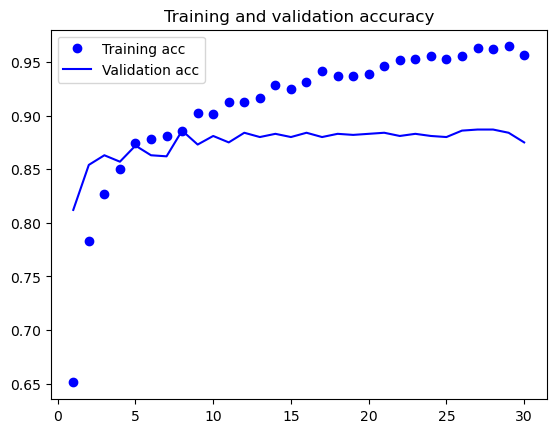

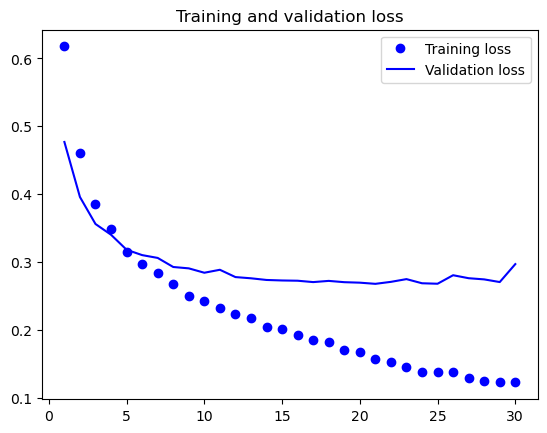

In [6]:
# plotting the results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Fast Feature Extraction with Data Augmentation

In [7]:
import keras

# Create new model on top
inputs = keras.Input(shape=(128, 128, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

In [8]:
from tensorflow.keras import Model, layers, Input

# Assuming conv_base is your pre-trained model and inputs is your input layer
inputs = Input(shape=(128, 128, 3))
x = conv_base(inputs, training=False)  # Apply conv_base to the inputs
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.summary()
# Continue with model compilation and training

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 30
Number of trainable weights after freezing the conv base: 4


In [10]:
# training the model end to end with a frozen convolutional base

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # validation data should not be augmented

train_generator = train_datagen.flow_from_directory(
    train_dir, # target directory
    target_size=(128, 128), # resize all images to 150x150
    batch_size=20, 
    class_mode='binary') # binary labels

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(128, 128), 
    batch_size=20, 
    class_mode='binary')

model.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(learning_rate=2e-5),
               metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=32,  # 2000 images = batch_size * steps 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=16)  # 1000 images = batch_size * steps
    

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


/home/cai/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - acc: 0.4821 - loss: 0.7916 - val_acc: 0.6344 - val_loss: 0.6535
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.5514 - loss: 0.7080 - val_acc: 0.7094 - val_loss: 0.5993
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - acc: 0.6442 - loss: 0.6297 - val_acc: 0.7375 - val_loss: 0.5375
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6771 - loss: 0.5707 - val_acc: 0.7000 - val_loss: 0.5734
Epoch 5/30


2024-07-12 00:51:12.217096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:12.217123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 00:51:12.217129: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 00:51:12.217135: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
/home/cai/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(ty

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - acc: 0.6961 - loss: 0.6123 - val_acc: 0.7719 - val_loss: 0.5219
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.6932 - loss: 0.5849 - val_acc: 0.7594 - val_loss: 0.5135
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - acc: 0.7150 - loss: 0.5637 - val_acc: 0.7906 - val_loss: 0.4817
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6926 - loss: 0.5365 - val_acc: 0.8500 - val_loss: 0.4849
Epoch 9/30


2024-07-12 00:51:17.611908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:17.611930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 00:51:17.611935: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 00:51:17.611942: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 00:51:17.631013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:17.631031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - acc: 0.7040 - loss: 0.5628 - val_acc: 0.8281 - val_loss: 0.4332
Epoch 10/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.8116 - loss: 0.4623 - val_acc: 0.8062 - val_loss: 0.4415
Epoch 11/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.7432 - loss: 0.5152 - val_acc: 0.8156 - val_loss: 0.4099
Epoch 12/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7887 - loss: 0.4505 - val_acc: 0.7000 - val_loss: 0.4672
Epoch 13/30


2024-07-12 00:51:22.997605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:22.997633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 00:51:22.997643: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 00:51:22.997654: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 00:51:23.014989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:23.015013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - acc: 0.7307 - loss: 0.5168 - val_acc: 0.7688 - val_loss: 0.4486
Epoch 14/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.7485 - loss: 0.5259 - val_acc: 0.8500 - val_loss: 0.4094
Epoch 15/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.7459 - loss: 0.5196 - val_acc: 0.8250 - val_loss: 0.3931
Epoch 16/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8273 - loss: 0.3826 - val_acc: 0.9000 - val_loss: 0.3746
Epoch 17/30


2024-07-12 00:51:28.392748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:28.392778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 00:51:28.392788: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 00:51:28.392799: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 00:51:28.411790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:28.411814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - acc: 0.7739 - loss: 0.4641 - val_acc: 0.8375 - val_loss: 0.3807
Epoch 18/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.7477 - loss: 0.4988 - val_acc: 0.8438 - val_loss: 0.3710
Epoch 19/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.7607 - loss: 0.4820 - val_acc: 0.8438 - val_loss: 0.3863
Epoch 20/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8605 - loss: 0.4304 - val_acc: 0.7750 - val_loss: 0.3661
Epoch 21/30


2024-07-12 00:51:33.794597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:33.794638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 00:51:33.794648: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 00:51:33.794660: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 00:51:33.813662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:33.813700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - acc: 0.7511 - loss: 0.5051 - val_acc: 0.8313 - val_loss: 0.3891
Epoch 22/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - acc: 0.7963 - loss: 0.4422 - val_acc: 0.8813 - val_loss: 0.3095
Epoch 23/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.7889 - loss: 0.4588 - val_acc: 0.8531 - val_loss: 0.3468
Epoch 24/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7167 - loss: 0.4878 - val_acc: 0.7500 - val_loss: 0.4210
Epoch 25/30


2024-07-12 00:51:39.121908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:39.121950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 00:51:39.121960: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 00:51:39.121971: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 00:51:39.140084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:39.140100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - acc: 0.7958 - loss: 0.4152 - val_acc: 0.8531 - val_loss: 0.3380
Epoch 26/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.8309 - loss: 0.4148 - val_acc: 0.8344 - val_loss: 0.3674
Epoch 27/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - acc: 0.7903 - loss: 0.4434 - val_acc: 0.8656 - val_loss: 0.3270
Epoch 28/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7895 - loss: 0.4673 - val_acc: 0.8250 - val_loss: 0.3592
Epoch 29/30


2024-07-12 00:51:44.569974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:44.570006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 00:51:44.570016: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 00:51:44.570027: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 00:51:44.589329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 00:51:44.589346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - acc: 0.8169 - loss: 0.4141 - val_acc: 0.8531 - val_loss: 0.3455
Epoch 30/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.7842 - loss: 0.4632 - val_acc: 0.8594 - val_loss: 0.3398


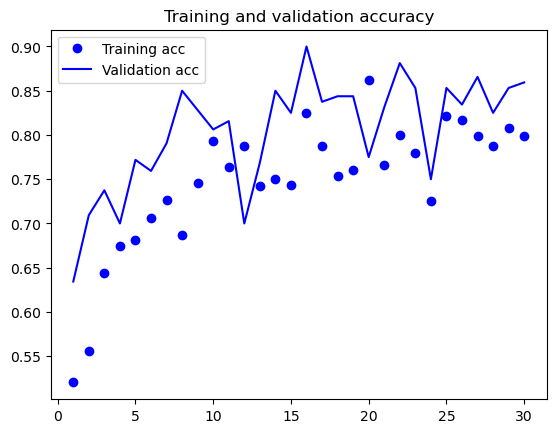

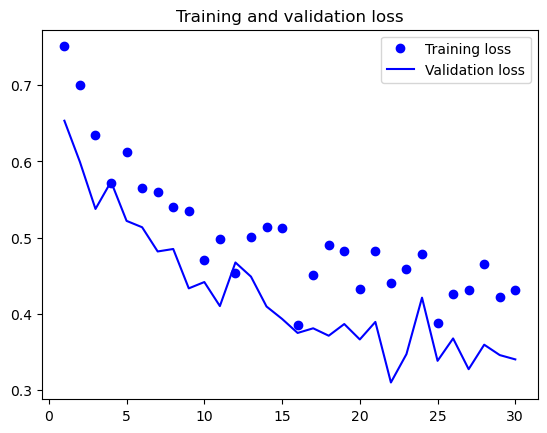

In [11]:
# plotting the results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##### Fine-Tuning

In [12]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# freezing all layers up to a specific one

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [23]:
# fine-tuning the model

model.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(learning_rate=2e-5),
               metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=24,  # 2000 images = batch_size * steps
    epochs=100,
    validation_data=validation_generator,
    validation_steps=12)  # 1000 images = batch_size * steps

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - acc: 0.9662 - loss: 0.0999 - val_acc: 0.9000 - val_loss: 0.5514
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - acc: 0.9363 - loss: 0.1353 - val_acc: 0.9125 - val_loss: 0.3925
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.9632 - loss: 0.0773 - val_acc: 0.9375 - val_loss: 0.3173
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.9699 - loss: 0.0591 - val_acc: 0.9292 - val_loss: 0.3864
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 1.0000 - loss: 0.0141 - val_acc: 0.9750 - val_loss: 0.1024
Epoch 6/100


2024-07-12 01:00:36.581789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:00:36.581901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-12 01:00:36.602165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:00:36.602185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:00:36.602190: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:00:36.602196: I tensorflow/core/framework/local_ren

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - acc: 0.9414 - loss: 0.1306 - val_acc: 0.9375 - val_loss: 0.2354
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - acc: 0.9770 - loss: 0.0784 - val_acc: 0.9333 - val_loss: 0.2133
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - acc: 0.9808 - loss: 0.0467 - val_acc: 0.9292 - val_loss: 0.2997
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc: 0.9872 - loss: 0.0563 - val_acc: 0.8917 - val_loss: 0.4126
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9767 - loss: 0.0814 - val_acc: 0.9250 - val_loss: 0.2052
Epoch 11/100


2024-07-12 01:00:41.673666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:00:41.673689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:00:41.673705: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:00:41.673711: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:00:41.692770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:00:41.692803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - acc: 0.9769 - loss: 0.0582 - val_acc: 0.8917 - val_loss: 0.3443
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - acc: 0.9760 - loss: 0.0818 - val_acc: 0.8833 - val_loss: 0.3996
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.9859 - loss: 0.0323 - val_acc: 0.9292 - val_loss: 0.2130
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.9813 - loss: 0.0359 - val_acc: 0.9333 - val_loss: 0.3326
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9634 - loss: 0.0698 - val_acc: 0.8500 - val_loss: 0.7892
Epoch 16/100


2024-07-12 01:00:46.658610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:00:46.658645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:00:46.658655: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:00:46.658668: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:00:46.677136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:00:46.677168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.9836 - loss: 0.0508 - val_acc: 0.9500 - val_loss: 0.2621
Epoch 17/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - acc: 0.9845 - loss: 0.0706 - val_acc: 0.9000 - val_loss: 0.4880
Epoch 18/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - acc: 0.9686 - loss: 0.0852 - val_acc: 0.9083 - val_loss: 0.2683
Epoch 19/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.9766 - loss: 0.0654 - val_acc: 0.9500 - val_loss: 0.2427
Epoch 20/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9891 - loss: 0.0310 - val_acc: 0.9500 - val_loss: 0.2977
Epoch 21/100


2024-07-12 01:00:51.669989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:00:51.670023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:00:51.670033: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:00:51.670047: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:00:51.689026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:00:51.689079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - acc: 0.9765 - loss: 0.0507 - val_acc: 0.9250 - val_loss: 0.3518
Epoch 22/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - acc: 0.9511 - loss: 0.1340 - val_acc: 0.9292 - val_loss: 0.3119
Epoch 23/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - acc: 0.9722 - loss: 0.0729 - val_acc: 0.9333 - val_loss: 0.2337
Epoch 24/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.9708 - loss: 0.0833 - val_acc: 0.9083 - val_loss: 0.3251
Epoch 25/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9764 - loss: 0.0686 - val_acc: 0.8250 - val_loss: 0.6900
Epoch 26/100


2024-07-12 01:00:56.664909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:00:56.664938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:00:56.664948: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:00:56.664959: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:00:56.685384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:00:56.685404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - acc: 0.9842 - loss: 0.0374 - val_acc: 0.9208 - val_loss: 0.3668
Epoch 27/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - acc: 0.9749 - loss: 0.0488 - val_acc: 0.9542 - val_loss: 0.1834
Epoch 28/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - acc: 0.9754 - loss: 0.0696 - val_acc: 0.9042 - val_loss: 0.3634
Epoch 29/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.9758 - loss: 0.0668 - val_acc: 0.8958 - val_loss: 0.6845
Epoch 30/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9852 - loss: 0.0807 - val_acc: 0.9500 - val_loss: 0.1946
Epoch 31/100


2024-07-12 01:01:01.696930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:01.696962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:01.696971: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:01.696982: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:01:01.717194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:01.717228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - acc: 0.9780 - loss: 0.0627 - val_acc: 0.9375 - val_loss: 0.2764
Epoch 32/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - acc: 0.9857 - loss: 0.0474 - val_acc: 0.9292 - val_loss: 0.3291
Epoch 33/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.9783 - loss: 0.0421 - val_acc: 0.9042 - val_loss: 0.4791
Epoch 34/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.9828 - loss: 0.0414 - val_acc: 0.9458 - val_loss: 0.3436
Epoch 35/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9852 - loss: 0.0406 - val_acc: 0.9750 - val_loss: 0.0889
Epoch 36/100


2024-07-12 01:01:06.878161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:06.878182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:06.878188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:06.878194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:01:06.895675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:06.895705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - acc: 0.9770 - loss: 0.0566 - val_acc: 0.9292 - val_loss: 0.1956
Epoch 37/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - acc: 0.9681 - loss: 0.0944 - val_acc: 0.9167 - val_loss: 0.4313
Epoch 38/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - acc: 0.9881 - loss: 0.0351 - val_acc: 0.9500 - val_loss: 0.2758
Epoch 39/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.9768 - loss: 0.0512 - val_acc: 0.9292 - val_loss: 0.3239
Epoch 40/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9884 - loss: 0.0496 - val_acc: 0.9750 - val_loss: 0.0524
Epoch 41/100


2024-07-12 01:01:11.987794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:11.987818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:11.987824: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:11.987830: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:01:12.008119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:12.008146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - acc: 0.9956 - loss: 0.0199 - val_acc: 0.8917 - val_loss: 0.5925
Epoch 42/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - acc: 0.9897 - loss: 0.0440 - val_acc: 0.9458 - val_loss: 0.2727
Epoch 43/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.9746 - loss: 0.0595 - val_acc: 0.9125 - val_loss: 0.3943
Epoch 44/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.9867 - loss: 0.0364 - val_acc: 0.9292 - val_loss: 0.3563
Epoch 45/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9648 - loss: 0.0671 - val_acc: 0.9250 - val_loss: 0.6008
Epoch 46/100


2024-07-12 01:01:17.168120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:17.168176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:17.168393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:17.187178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:17.187202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:17.187211: I tensorflow/core/framework/local_ren

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - acc: 0.9887 - loss: 0.0236 - val_acc: 0.9042 - val_loss: 0.5282
Epoch 47/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - acc: 0.9679 - loss: 0.0815 - val_acc: 0.9042 - val_loss: 0.4480
Epoch 48/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - acc: 0.9796 - loss: 0.0367 - val_acc: 0.9292 - val_loss: 0.3608
Epoch 49/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.9826 - loss: 0.0536 - val_acc: 0.9208 - val_loss: 0.3588
Epoch 50/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9736 - loss: 0.0769 - val_acc: 0.9000 - val_loss: 0.1953
Epoch 51/100


2024-07-12 01:01:22.321525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:22.321558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:22.321564: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:22.321571: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:01:22.341442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:22.341456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - acc: 0.9893 - loss: 0.0303 - val_acc: 0.9292 - val_loss: 0.2630
Epoch 52/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - acc: 0.9867 - loss: 0.0429 - val_acc: 0.9458 - val_loss: 0.1615
Epoch 53/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - acc: 0.9770 - loss: 0.0582 - val_acc: 0.9125 - val_loss: 0.4821
Epoch 54/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.9717 - loss: 0.0633 - val_acc: 0.9417 - val_loss: 0.2855
Epoch 55/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9736 - loss: 0.0659 - val_acc: 0.9250 - val_loss: 0.5765
Epoch 56/100


2024-07-12 01:01:27.457236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:27.457389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-12 01:01:27.475564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:27.475576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - acc: 0.9885 - loss: 0.0353 - val_acc: 0.9000 - val_loss: 0.5088
Epoch 57/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - acc: 0.9778 - loss: 0.0560 - val_acc: 0.9417 - val_loss: 0.2999
Epoch 58/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - acc: 0.9769 - loss: 0.0643 - val_acc: 0.9167 - val_loss: 0.3365
Epoch 59/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.9861 - loss: 0.0338 - val_acc: 0.9042 - val_loss: 0.3710
Epoch 60/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 1.0000 - loss: 0.0115 - val_acc: 0.9500 - val_loss: 0.2543
Epoch 61/100


2024-07-12 01:01:32.631673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:32.631694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:32.631699: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:32.631705: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:01:32.653678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:32.653694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - acc: 0.9939 - loss: 0.0202 - val_acc: 0.9167 - val_loss: 0.4359
Epoch 62/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - acc: 0.9741 - loss: 0.0485 - val_acc: 0.9375 - val_loss: 0.3380
Epoch 63/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.9788 - loss: 0.0647 - val_acc: 0.8917 - val_loss: 0.4195
Epoch 64/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc: 0.9742 - loss: 0.0645 - val_acc: 0.8667 - val_loss: 0.7233
Epoch 65/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9627 - loss: 0.0587 - val_acc: 0.9000 - val_loss: 0.6654
Epoch 66/100


2024-07-12 01:01:37.887107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:37.887162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:37.887186: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:37.887214: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:01:37.910434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:37.910454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - acc: 0.9841 - loss: 0.0374 - val_acc: 0.9375 - val_loss: 0.2929
Epoch 67/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - acc: 0.9910 - loss: 0.0294 - val_acc: 0.8958 - val_loss: 0.6578
Epoch 68/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.9774 - loss: 0.0626 - val_acc: 0.8875 - val_loss: 0.7058
Epoch 69/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.9745 - loss: 0.1310 - val_acc: 0.9250 - val_loss: 0.3592
Epoch 70/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9781 - loss: 0.0342 - val_acc: 0.9500 - val_loss: 0.3067
Epoch 71/100


2024-07-12 01:01:43.184761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:43.184780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:43.184784: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:43.184790: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:01:43.203987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:43.204006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - acc: 0.9844 - loss: 0.0430 - val_acc: 0.9333 - val_loss: 0.3969
Epoch 72/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - acc: 0.9894 - loss: 0.0344 - val_acc: 0.9000 - val_loss: 0.4892
Epoch 73/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - acc: 0.9788 - loss: 0.0565 - val_acc: 0.9333 - val_loss: 0.1925
Epoch 74/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 0.9899 - loss: 0.0346 - val_acc: 0.9375 - val_loss: 0.3699
Epoch 75/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 1.0000 - loss: 0.0122 - val_acc: 0.9000 - val_loss: 0.3168
Epoch 76/100


2024-07-12 01:01:48.466687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:48.466721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:48.466731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:48.466742: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:01:48.486905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:48.486924: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key ha

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - acc: 0.9859 - loss: 0.0457 - val_acc: 0.9458 - val_loss: 0.3316
Epoch 77/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - acc: 0.9824 - loss: 0.0578 - val_acc: 0.9250 - val_loss: 0.4426
Epoch 78/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.9820 - loss: 0.0520 - val_acc: 0.9167 - val_loss: 0.3335
Epoch 79/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.9881 - loss: 0.0295 - val_acc: 0.9333 - val_loss: 0.2641
Epoch 80/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9884 - loss: 0.0208 - val_acc: 0.9500 - val_loss: 0.2270
Epoch 81/100


2024-07-12 01:01:53.722799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:53.722820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:53.722829: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:53.722835: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:01:53.742693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:53.742713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - acc: 0.9884 - loss: 0.0270 - val_acc: 0.9333 - val_loss: 0.3661
Epoch 82/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - acc: 0.9903 - loss: 0.0551 - val_acc: 0.9042 - val_loss: 0.4902
Epoch 83/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - acc: 0.9731 - loss: 0.0725 - val_acc: 0.9375 - val_loss: 0.3620
Epoch 84/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 0.9898 - loss: 0.0244 - val_acc: 0.9083 - val_loss: 0.5335
Epoch 85/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 1.0000 - loss: 0.0203 - val_acc: 0.9250 - val_loss: 0.6822
Epoch 86/100


2024-07-12 01:01:59.044183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:59.044205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:01:59.044210: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:01:59.044216: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:01:59.064694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:01:59.064709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - acc: 0.9832 - loss: 0.0507 - val_acc: 0.9500 - val_loss: 0.3443
Epoch 87/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - acc: 0.9861 - loss: 0.0645 - val_acc: 0.9417 - val_loss: 0.4197
Epoch 88/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.9734 - loss: 0.0697 - val_acc: 0.9333 - val_loss: 0.3789
Epoch 89/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 0.9838 - loss: 0.0347 - val_acc: 0.9458 - val_loss: 0.3863
Epoch 90/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 1.0000 - loss: 0.0095 - val_acc: 0.9500 - val_loss: 0.2642
Epoch 91/100


2024-07-12 01:02:04.324534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:02:04.324563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:02:04.324572: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:02:04.324582: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:02:04.345402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:02:04.345422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - acc: 0.9835 - loss: 0.0545 - val_acc: 0.9333 - val_loss: 0.3784
Epoch 92/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - acc: 0.9915 - loss: 0.0268 - val_acc: 0.9333 - val_loss: 0.4150
Epoch 93/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.9929 - loss: 0.0220 - val_acc: 0.9375 - val_loss: 0.2782
Epoch 94/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 0.9953 - loss: 0.0203 - val_acc: 0.9250 - val_loss: 0.3505
Epoch 95/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9578 - loss: 0.0595 - val_acc: 0.9750 - val_loss: 0.2162
Epoch 96/100


2024-07-12 01:02:09.702285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:02:09.702315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:02:09.702326: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:02:09.702338: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5223993779770756028
2024-07-12 01:02:09.722488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:02:09.722510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - acc: 0.9730 - loss: 0.0435 - val_acc: 0.9333 - val_loss: 0.3775
Epoch 97/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - acc: 0.9827 - loss: 0.0995 - val_acc: 0.9458 - val_loss: 0.2375
Epoch 98/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.9779 - loss: 0.0714 - val_acc: 0.9458 - val_loss: 0.3765
Epoch 99/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - acc: 0.9958 - loss: 0.0216 - val_acc: 0.9458 - val_loss: 0.4058
Epoch 100/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9873 - loss: 0.0250 - val_acc: 0.9500 - val_loss: 0.1251


2024-07-12 01:02:15.047706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:02:15.047946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-12 01:02:15.067504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 01:02:15.067524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-12 01:02:15.067533: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2568938030066609733
2024-07-12 01:02:15.067545: I tensorflow/core/framework/local_ren

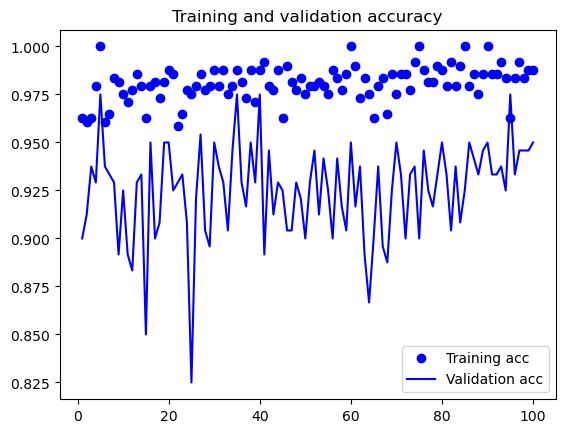

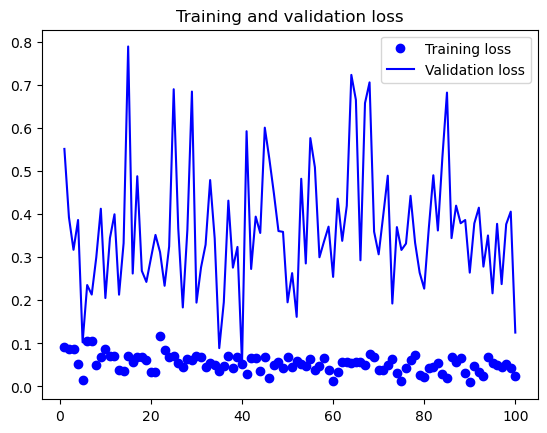

In [24]:
# plotting the results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

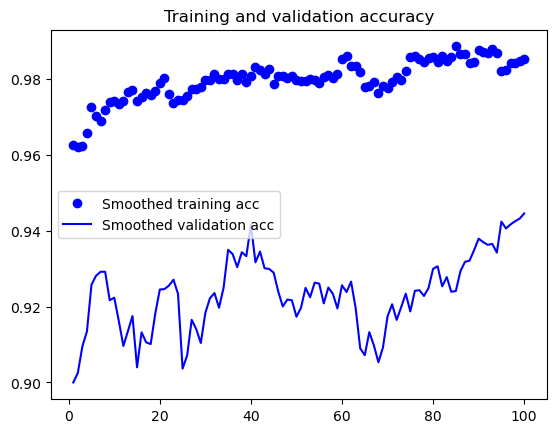

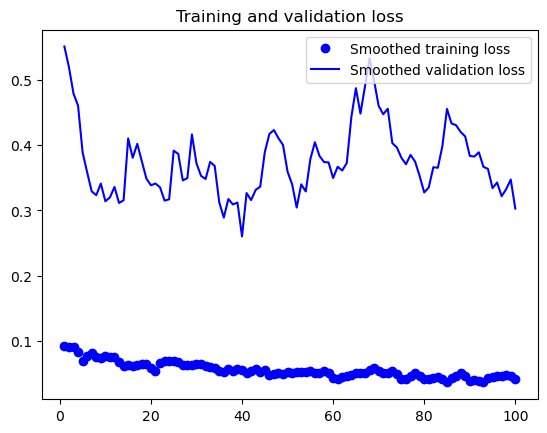

In [25]:
# smoothing the plots

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(128, 128), 
    batch_size=20, 
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - acc: 0.9241 - loss: 0.4073
test acc: 0.9179999828338623
